In [21]:
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, RNN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import sys

In [3]:
df = pd.read_csv('../data/scraped_weather_2010_2025.csv',index_col=0)

In [4]:
df.head()

,Date,Temperature,Dew Point,Wind Direction,Wind Speed,Gust,Pressure,Condition
0,20100101,[10. 10. 10. 10. ...,[6.11111111 6.11111111 7.22222222 7.22222222 7...,[240 270 250 250 250 250 250 250 270 270 250 2...,[7 6 7 7 7 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 3 6 5 5],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[27.45 27.45 27.45 27.45 27.45 27.43 27.48 27....,['Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Partly Cl...
1,20100102,[10. 10. 10. 11.111111...,[ 7.22222222 7.22222222 6.11111111 7.222222...,[200 210 210 200 210 230 210 210 230 230 0 2...,[6 6 3 5 6 3 5 5 5 3 0 7 9 9 9 5 5 5 5 5 5],[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[27.48 27.48 27.48 27.45 27.45 27.45 27.45 27....,['Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Fa...
2,20100103,[12.77777778 12.77777778 12.22222222 12.777777...,[1.11111111 1.11111111 2.22222222 2.77777778 2...,[210 220 0 0 0 200 200 230 250 250 250 2...,[ 5 5 0 0 0 5 5 6 5 9 9 9 8 14 9 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[27.4 27.4 27.37 27.37 27.37 27.37 27.37 27....,['Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Fa...
3,20100104,[10. 10. 10. 10. ...,[7.22222222 7.22222222 7.22222222 7.77777778 7...,[220 210 210 210 220 240 250 250 260 260 270 2...,[ 9 5 3 3 5 5 8 8 9 16 13 15 15 16 16 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[27.43 27.43 27.45 27.43 27.45 27.45 27.43 27....,['Partly Cloudy' 'Partly Cloudy' 'Partly Cloud...
4,20100105,[10. 10. 10. 10. ...,[7.77777778 7.77777778 7.77777778 7.22222222 7...,[250 250 210 230 240 240 240 240 240 240 250 3...,[ 5 5 7 10 7 5 5 7 5 6 5 3 6 5 5 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[27.48 27.48 27.48 27.48 27.48 27.48 27.51 27....,['Mostly Cloudy' 'Mostly Cloudy' 'Partly Cloud...


In [5]:
df_dic = df.loc[0]

In [6]:
df_dic

Date                                                       20100101
Temperature       [10.         10.         10.         10.      ...
Dew Point         [6.11111111 6.11111111 7.22222222 7.22222222 7...
Wind Direction    [240 270 250 250 250 250 250 250 270 270 250 2...
Wind Speed        [7 6 7 7 7 9 9 9 9 9 9 9 9 9 9 9 9 9 5 3 3 6 5 5]
Gust              [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pressure          [27.45 27.45 27.45 27.45 27.45 27.43 27.48 27....
Condition         ['Fair' 'Fair' 'Fair' 'Fair' 'Fair' 'Partly Cl...
Name: 0, dtype: object

In [7]:
df_temps = df_dic['Temperature'][1:-1].split()

In [37]:
def get_datetime_data(index):
    date_string = df.loc[index]['Date']
    hourly_temp = df.loc[index]['Temperature'][1:-1].split()
    hourly_condition = df.loc[index]['Condition'][1:-1].replace('\'', '').split()
    hourly_wind_dir = df.loc[index]['Wind Direction'][1:-1].split()
    hourly_wind_spd = df.loc[index]['Wind Speed'][1:-1].split()

    MIN_READINGS = 20
    DAY_HOURS = 24
    num_readings = len(hourly_temp)
    
    if num_readings > DAY_HOURS:
        hourly_temp = hourly_temp[:DAY_HOURS]
        hourly_condition = hourly_condition[:DAY_HOURS]
        hourly_wind_dir = hourly_wind_dir[:DAY_HOURS]
        hourly_wind_spd = hourly_wind_spd[:DAY_HOURS]

    # print(num_readings)
    if num_readings < MIN_READINGS:
       return None

    if num_readings < DAY_HOURS:
        for _ in range(num_readings, DAY_HOURS):
            hourly_temp.append(hourly_temp[-1])
            hourly_condition.append(hourly_condition[-1])
            hourly_wind_dir.append(hourly_wind_dir[-1])
            hourly_wind_spd.append(hourly_wind_spd[-1])

    
    
    dt_list = []
    for hour in range(len(hourly_temp)):
        dt = datetime.strptime(f'{date_string} {hour}', '%Y%m%d %H')
        dt_list.append(dt) 

    hourly_temp_np = np.array(hourly_temp, np.float32)
    hourly_wind_dir_np = np.array(hourly_wind_dir, np.float32)
    hourly_wind_spd_np = np.array(hourly_wind_spd, np.float32)


    list_of_days = []
    for hour in range(DAY_HOURS):
        
        dic = {
            'Datetime' : dt_list[hour],
            'Temperature' : hourly_temp_np[hour],
            'Condiction' : hourly_condition[hour],
            'Wind Direction' : hourly_wind_dir_np[hour],
            'Wind Speed' : hourly_wind_spd_np[hour],
        }
        list_of_days.append(dic)

    return list_of_days

In [38]:
data_datetime = []

for day in range(len(df)):
    try:
        data = get_datetime_data(day)
        data_datetime.append(data)
    except Exception as e:
        print(day)
        print(e)

In [41]:
data_datetime = [i for i in data_datetime if i]

In [42]:
data_datetime_seq = [i for sub in data_datetime for i in sub if sub]

In [43]:
data_datetime_seq[0:5]

[{'Datetime': datetime.datetime(2010, 1, 1, 0, 0),
  'Temperature': np.float32(10.0),
  'Condiction': 'Fair',
  'Wind Direction': np.float32(240.0),
  'Wind Speed': np.float32(7.0)},
 {'Datetime': datetime.datetime(2010, 1, 1, 1, 0),
  'Temperature': np.float32(10.0),
  'Condiction': 'Fair',
  'Wind Direction': np.float32(270.0),
  'Wind Speed': np.float32(6.0)},
 {'Datetime': datetime.datetime(2010, 1, 1, 2, 0),
  'Temperature': np.float32(10.0),
  'Condiction': 'Fair',
  'Wind Direction': np.float32(250.0),
  'Wind Speed': np.float32(7.0)},
 {'Datetime': datetime.datetime(2010, 1, 1, 3, 0),
  'Temperature': np.float32(10.0),
  'Condiction': 'Fair',
  'Wind Direction': np.float32(250.0),
  'Wind Speed': np.float32(7.0)},
 {'Datetime': datetime.datetime(2010, 1, 1, 4, 0),
  'Temperature': np.float32(11.111111),
  'Condiction': 'Fair',
  'Wind Direction': np.float32(250.0),
  'Wind Speed': np.float32(7.0)}]

In [44]:
sys.getsizeof(data_datetime_seq)

1140568

In [85]:
df2 = pd.DataFrame(data_datetime_seq)

In [86]:
df2.head()

,Datetime,Temperature,Condiction,Wind Direction,Wind Speed
0,2010-01-01 00:00:00,10.000000,Fair,240.0,7.0
1,2010-01-01 01:00:00,10.000000,Fair,270.0,6.0
2,2010-01-01 02:00:00,10.000000,Fair,250.0,7.0
3,2010-01-01 03:00:00,10.000000,Fair,250.0,7.0
4,2010-01-01 04:00:00,11.111111,Fair,250.0,7.0


In [87]:
df2.loc[1120]

Datetime          2010-02-16 16:00:00
Temperature                 23.888889
Condiction                       Fair
Wind Direction                  260.0
Wind Speed                       18.0
Name: 1120, dtype: object

In [88]:
day_hours = 24
avg_month_len = 30

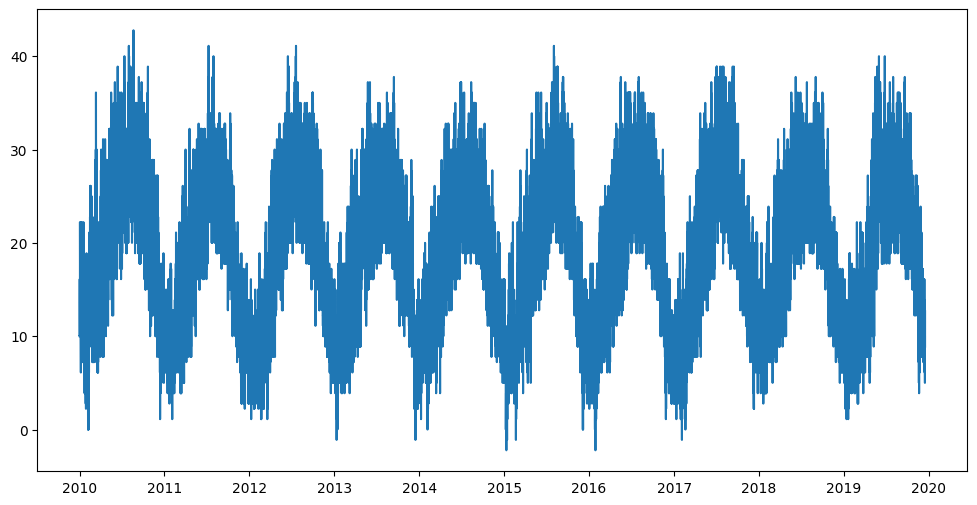

In [103]:
months = 12
years = 10

slice_date = day_hours * avg_month_len * months * years

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df2['Datetime'][:slice_date], df2['Temperature'][:slice_date])
plt.show()

In [93]:
threshold = -15

for i in range(1,len(df2)):
    if df2.loc[i, 'Temperature'] < threshold:
        df2.loc[i, 'Temperature'] = (df2.loc[i - 1, 'Temperature'] + df2.loc[i + 1, 'Temperature']) / 2 

In [70]:
s = df2['Temperature'].sort_values(ascending=True).unique()

In [72]:
s[1]

np.float32(-2.2222223)

In [73]:
df2['Temperature'] = df2['Temperature'].clip(lower=np.float32(-2.2222223))

{'whiskers': [<matplotlib.lines.Line2D at 0x7c1efb252150>,
 'caps': [<matplotlib.lines.Line2D at 0x7c1efb251b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c1efbbd4860>],
 'medians': [<matplotlib.lines.Line2D at 0x7c1efb251550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c1efb251280>],
 'means': []}

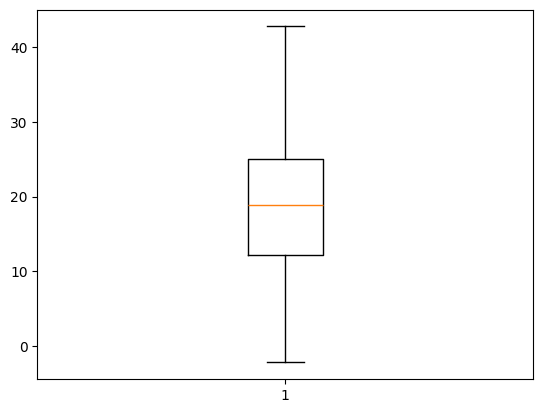

In [101]:
plt.boxplot(df2['Temperature'])

(array([2.6000e+01, 0.0000e+00, 1.2100e+02, 6.8970e+03, 3.0105e+04,
        2.9137e+04, 3.4262e+04, 2.7375e+04, 1.0249e+04, 8.6000e+02]),
 array([-17.77777863, -11.72222328,  -5.66666698,   0.38888931,
          6.44444466,  12.5       ,  18.55555725,  24.61111069,
         30.66666794,  36.72222519,  42.77777863]),
 <BarContainer object of 10 artists>)

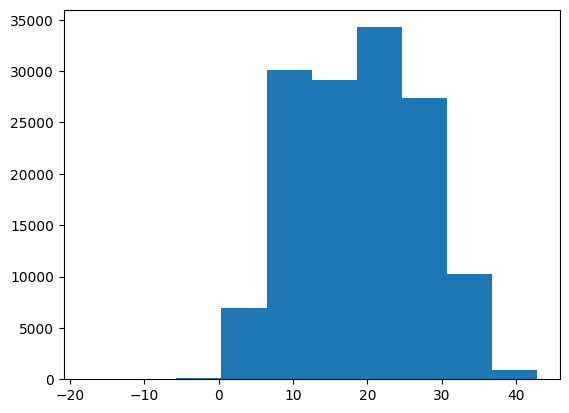

In [66]:
plt.hist(df2['Temperature'])

In [159]:
t_test = df.loc[4784]['Temperature'][1:-1].strip().replace('\n','').split()

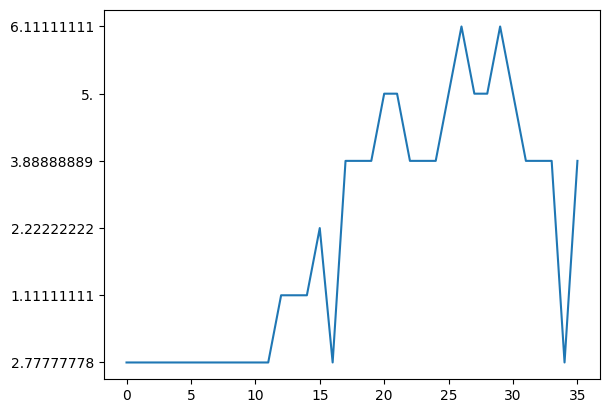

In [160]:
plt.plot(range(len(t_test)), t_test)

In [147]:
len(df)

5838

In [167]:
lengths = []
for day in range(len(df)):
    l = len(df.loc[day]['Temperature'][1:-1].strip().replace('\n','').split())
    lengths.append(l)

In [144]:
outliers = [i for i in lengths if i != 24]

(array([  4.,   2.,   2.,   0.,   1.,   1.,   3.,   1.,   1.,   4.,   1.,
          0.,   1.,   2.,   1.,   4.,   9.,   8.,  29.,  83., 264., 952.,
          0.,   0., 576., 175.,  67.,  24.,  13.,   1.,   3.,   1.,   0.,
          0.,   4.,   1.]),
 array([ 3.        ,  3.91666667,  4.83333333,  5.75      ,  6.66666667,
         7.58333333,  8.5       ,  9.41666667, 10.33333333, 11.25      ,
        12.16666667, 13.08333333, 14.        , 14.91666667, 15.83333333,
        16.75      , 17.66666667, 18.58333333, 19.5       , 20.41666667,
        21.33333333, 22.25      , 23.16666667, 24.08333333, 25.        ,
        25.91666667, 26.83333333, 27.75      , 28.66666667, 29.58333333,
        30.5       , 31.41666667, 32.33333333, 33.25      , 34.16666667,
        35.08333333, 36.        ]),
 <BarContainer object of 36 artists>)

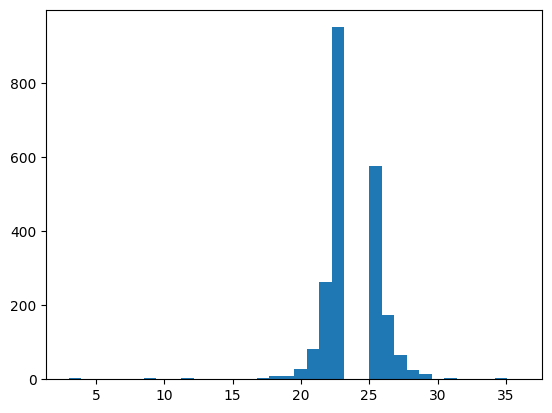

In [149]:
plt.hist(outliers,bins= 36)

In [142]:
lengths_np = np.array(lengths)

In [143]:
lengths_np.argmax()

np.int64(4784)

(array([  13.,   11.,  397., 5407.,   10.]),
 array([ 3. ,  9.6, 16.2, 22.8, 29.4, 36. ]),
 <BarContainer object of 5 artists>)

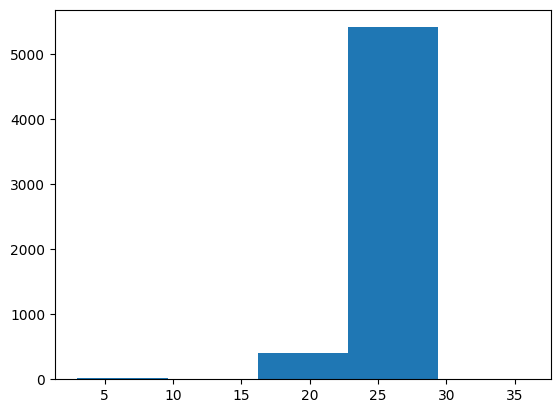

In [131]:
plt.hist(lengths,bins=5)

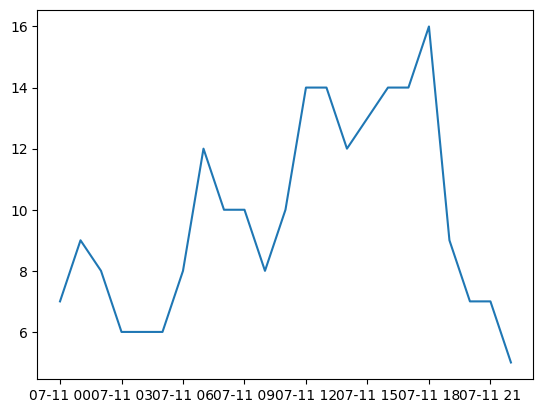

In [105]:
plt.plot(d['Datetime'], d['Wind Speed'])
plt.show()

In [102]:
d['Datetime'][0]

datetime.datetime(2014, 7, 11, 0, 0)

In [102]:
df2.to_csv('../data/preprocessed_data_2010_2025.csv')